In [1]:
from os.path import join
import json
import csv
import glob
import os

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem, ttest_rel
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)
library(grid)
library(gridExtra)
library(hexbin)

/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


In [4]:
empo3_dir = '/home/ben/Data/empo_3/'

In [5]:
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'weights.qza')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            try:
                samples = json.load(fh)
            except UnicodeDecodeError:
                print(join(fold_dir, 'sample_test.json'), 'is corrupted')
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

In [6]:
tpr = read_csv(join(empo3_dir, 'eval_taxa_tpr_species.tsv'), sep='\t')

In [7]:
folds = folds.set_index(['sample type', 'sample'])
tpr = tpr.join(folds, ['sample type', 'sample'])

In [8]:
tpr.head()

,Unnamed: 0,true positives,reads,species,class weights,sample type,sample,fold
0,0,6,6,k__Bacteria; p__[Thermi]; c__Deinococci; o__De...,bespoke70,animal-corpus,10798.MM.C.1A.2016.42736,1
1,1,9,9,k__Bacteria; p__Cyanobacteria; c__Oscillatorio...,bespoke70,animal-corpus,10798.MM.C.1A.2016.42736,1
2,2,32,40,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,bespoke70,animal-corpus,10798.MM.C.1A.2016.42736,1
3,3,1,7,k__Bacteria; p__Proteobacteria; c__Alphaproteo...,bespoke70,animal-corpus,10798.MM.C.1A.2016.42736,1
4,4,22,24,k__Bacteria; p__Proteobacteria; c__Alphaproteo...,bespoke70,animal-corpus,10798.MM.C.1A.2016.42736,1


In [9]:
grouped = tpr.groupby(['sample type', 'class weights', 'fold'])
def stat(x):
    tpr = 1. - x['true positives'].sum()/x['reads'].sum()
    return Series([tpr], index=['tpr'])
figure1 = grouped.apply(stat)
figure1.reset_index(inplace=True)

In [10]:
grouped = figure1.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    mu = x['tpr'].mean()
    se = sem(x['tpr'])
    lower, upper = mu-se, mu+se
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [11]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline',
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Other'] * 14 + ['Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['sample type'] == old, 'sample type'] = new

In [12]:
grouped = tpr.groupby(['species', 'class weights', 'fold'])
def stat(x):
    tpr = 1. - x['true positives'].sum()/x['reads'].sum()
    abundance = x['reads'].sum()
    return Series([tpr, abundance], index=['tpr', 'abundance'])
figure1 = grouped.apply(stat)
figure1.reset_index(inplace=True)

In [13]:
grouped = figure1.groupby(['species', 'class weights'])
def weighted_stats(x):
    mu = x['tpr'].mean()
    se = sem(x['tpr'])
    lower, upper = mu-se, mu+se
    abundance = x['abundance'].mean()
    return Series([mu, lower, upper, abundance], index=['mean', 'lower', 'upper', 'abundance'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)
figure1['abundance'] = 2*figure1['abundance']/figure1['abundance'].sum()

/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline',
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Other'] * 14 + ['Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new

In [15]:
uniform = figure1[figure1['class weights'] == 'Uniform']
bespoke = figure1[figure1['class weights'] == 'Bespoke']
diff = uniform.merge(bespoke, on='species', suffixes=(' uniform', ' bespoke'))
diff['diff'] = diff['mean bespoke'] - diff['mean uniform']

/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


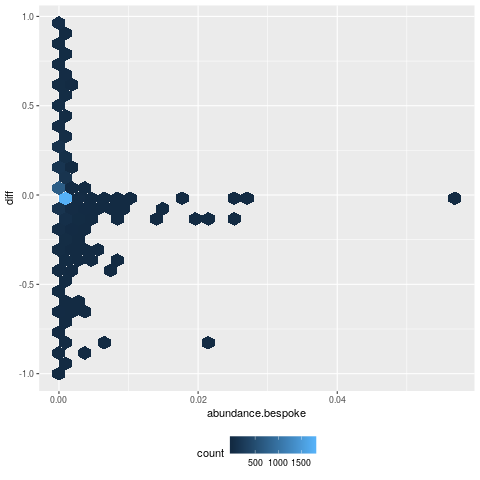

In [25]:
%%R -i diff
ggplot(data=diff, aes(x=abundance.bespoke, y=diff)) + geom_hex() + theme(legend.position='bottom')

In [60]:
%%R -i diff
# thanks https://stackoverflow.com/questions/8545035/scatterplot-with-marginal-histograms-in-ggplot2
empty <- ggplot()+geom_point(aes(1,1), colour="white")+
         theme(axis.ticks=element_blank(), 
               panel.background=element_blank(), 
               axis.text.x=element_blank(), axis.text.y=element_blank(),           
               axis.title.x=element_blank(), axis.title.y=element_blank())
scatter <- ggplot(data=diff, aes(x=abundance.bespoke, y=diff)) +
  geom_hex(bins=70) +
  #geom_point(size=0.1, alpha=0.5) +
  #geom_smooth(method='loess') +
  theme_bw() + theme(legend.position="bottom") + labs(fill="Count") +
  labs(x='Abundance', y='Bespoke Less Uniform Error Rate (%)') +
  scale_x_log10(limits = c(1e-8,1e-1),
                     expand = c(.05,.05)) +
  scale_y_continuous(limits = c(-1,1), expand = c(.05,.05))
hist_top <- ggplot(data=diff, aes(abundance.bespoke)) + 
    geom_freqpoly(colour='black', fill='grey', binwidth=0.15, aes(weight=abundance.bespoke)) + 
    scale_x_log10(limits = c(1e-8,1e-1),
                     expand = c(.05,.05)) +
    theme_bw() +
    theme(axis.title.x = element_blank(),
       axis.text.x = element_blank(),
       axis.ticks.x = element_blank(),
       panel.border = element_blank(),
       plot.margin = unit(c(0,2,0,1.2), "mm")) +
    labs(y='Frequency')
hist_right <- ggplot(data=diff, aes(diff)) + 
    geom_freqpoly(colour='black', fill='grey', binwidth=0.01, aes(weight=abundance.bespoke)) + 
    coord_flip() +
    scale_x_continuous(limits = c(-1,1), expand = c(.05,.05)) +
    scale_y_continuous(breaks = c(0,.1,.2)) +
    theme_bw() +
    theme(axis.title.y = element_blank(),
       axis.text.y = element_blank(),
       axis.ticks.y = element_blank(),
       panel.border = element_blank(),
       plot.margin = unit(c(2,0,21.5,0), "mm")) +
    labs(y='Frequency')
g <- arrangeGrob(hist_top, empty, scatter, hist_right, ncol=2, nrow=2, widths=c(4, 1), heights=c(1, 4))

ggsave('abundance-vs-error-rate-difference.png', g, width=5, height=7, dpi=300)

/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/home/ben/miniconda3/envs/qiime2-clean/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  Ignoring unknown parameters: fill

  warnings.warn(x, RRuntimeWarning)


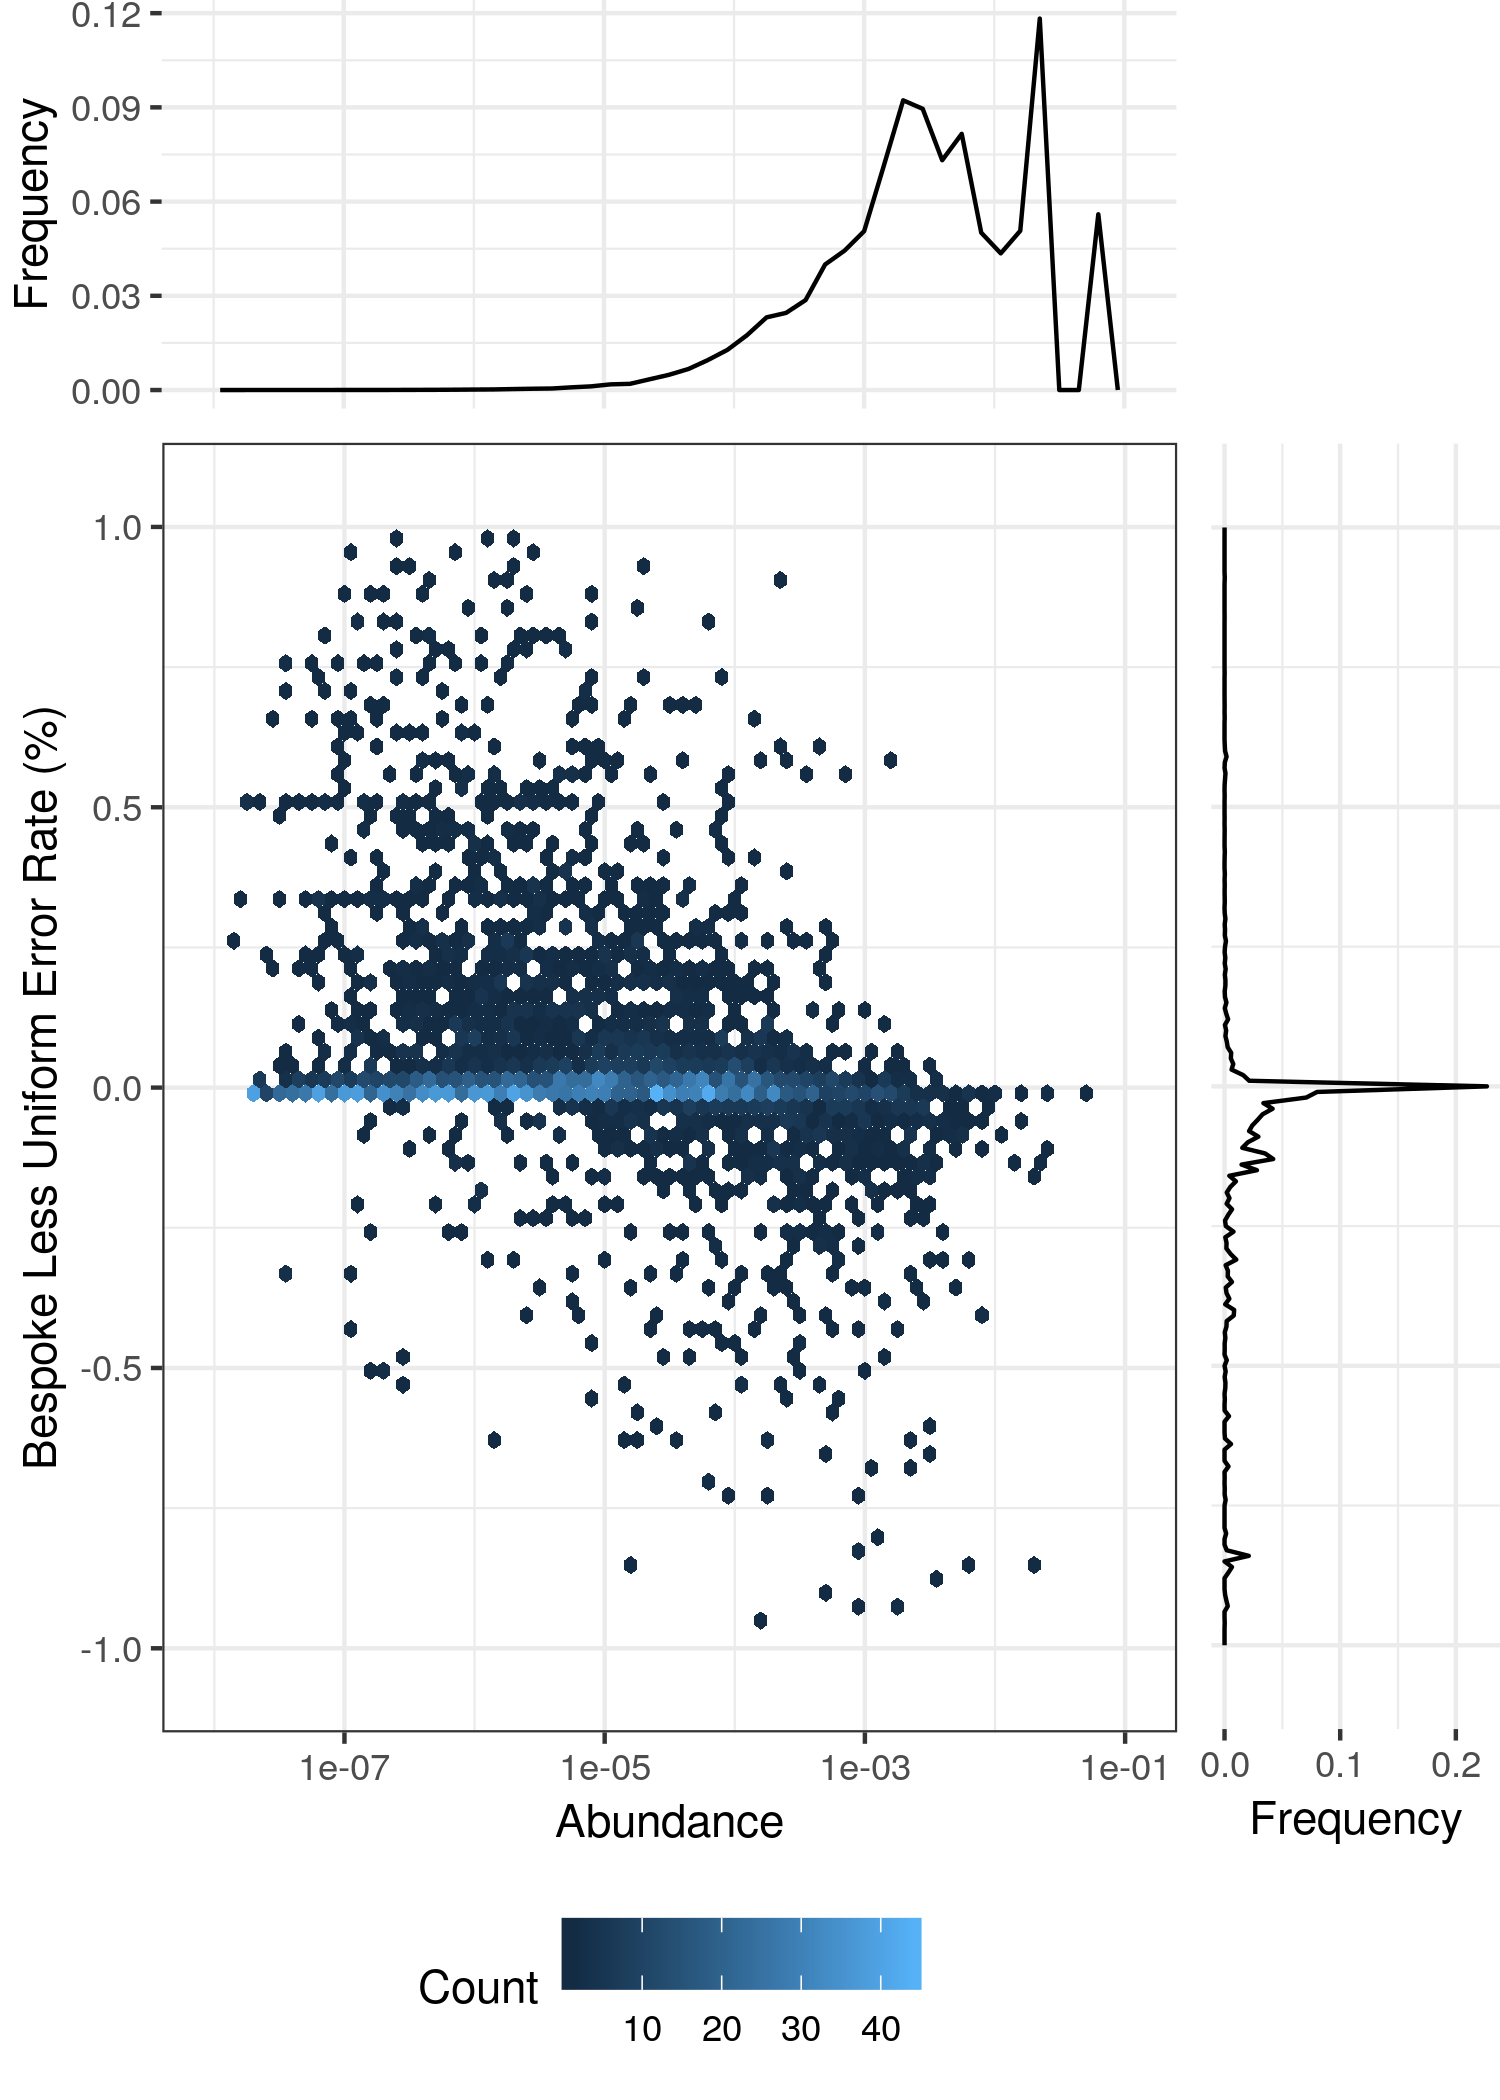

In [61]:
Image('abundance-vs-error-rate-difference.png')

In [22]:
%%R -i figure1
figure1$class.weights = factor(figure1$class.weights, levels=c(
    'Uniform', 'Bespoke'
))
fillPalette <- c("#56B4E9", "#009E73", "#E69F00", "#D4ECF9", "#BFE6DC", "#F8E7BF")
colourPalette <- c("#E69F00", "#009E73")
fillPalette <- colourPalette
p <- ggplot(data=figure1, aes(x=abundance, y=mean*100)) +
  geom_point(aes(colour=class.weights)) +
  geom_errorbar(aes(ymin=lower*100, ymax=upper*100, colour=class.weights)) +
  theme_bw() +
  labs(x='Abundance', y='Error Rate (%)') +
  scale_colour_manual(name='Taxonomic Weights', values=colourPalette) +
  theme(plot.margin = unit(c(1, 1, 2, 1), "lines"))

ggsave(file="abundance-vs-error-rate.png", width=5, height=7, dpi=300)

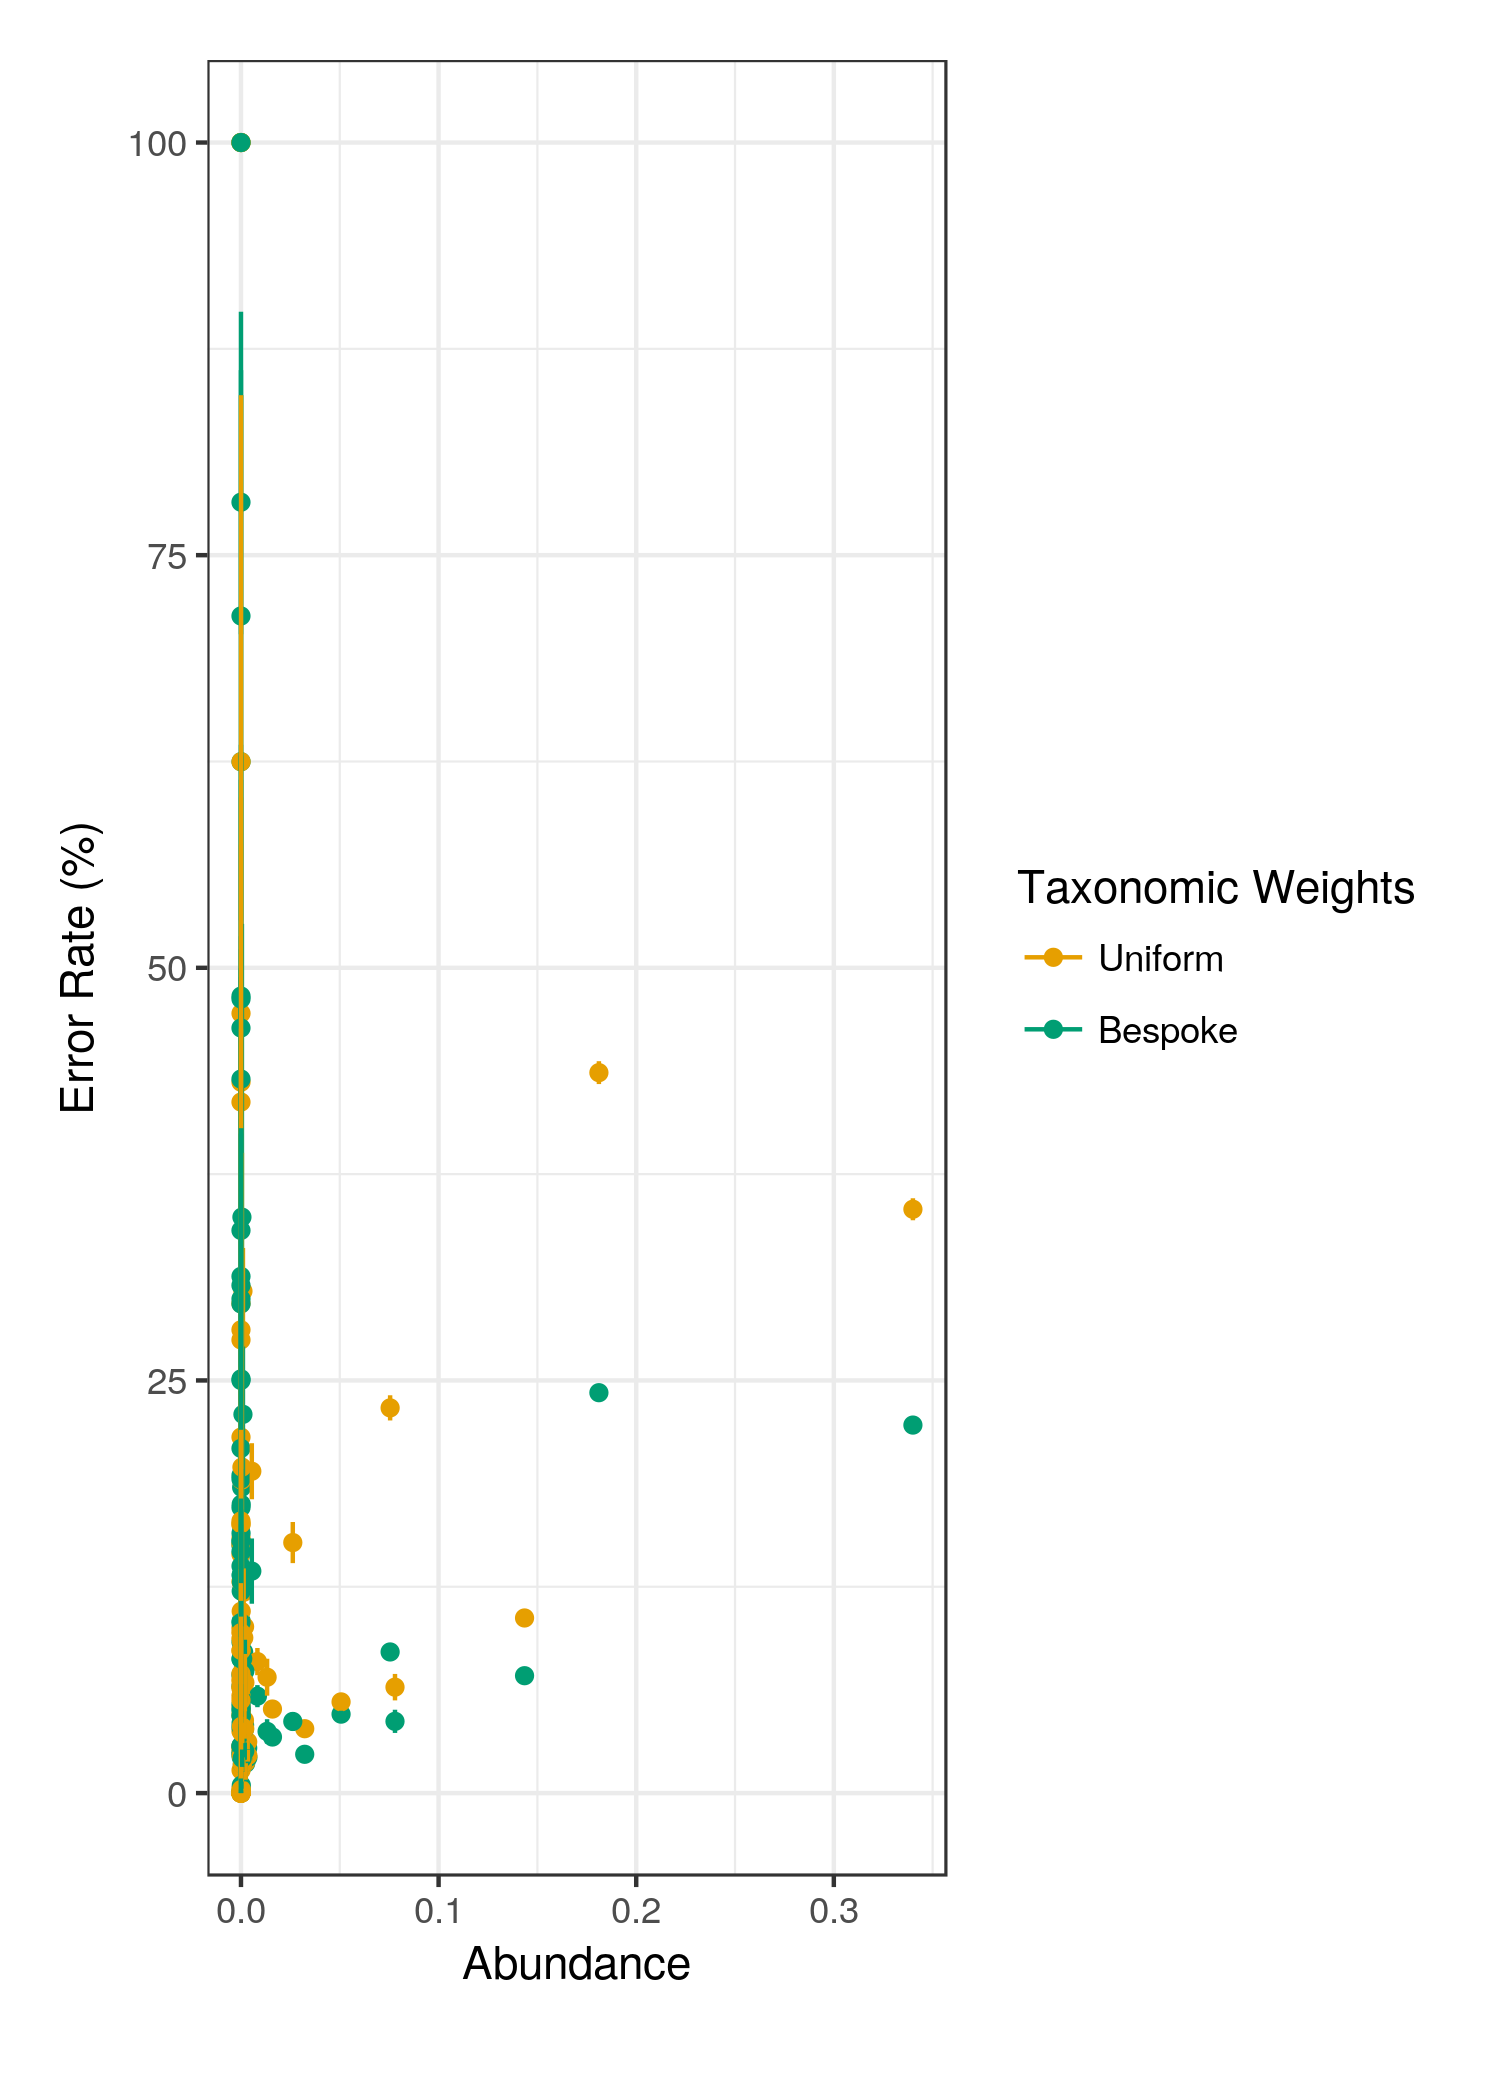

In [23]:
Image("abundance-vs-error-rate.png")

In [26]:
grouped = tpr.groupby(['phylum', 'class weights', 'fold'])
def stat(x):
    tpr = 1. - x['true positives'].sum()/x['reads'].sum()
    abundance = x['reads'].sum()
    return Series([tpr, abundance], index=['tpr', 'abundance'])
by_phylum = grouped.apply(stat)
by_phylum.reset_index(inplace=True)
phyla = [p.split('p__')[1] if 'p__' in p else p
         for p in by_phylum['phylum']]
phyla = [p if p != '' else 'No Phylum' for p in phyla]
by_phylum['phylum'] = phyla

In [27]:
firmicutes = by_phylum[by_phylum['phylum'] == 'Firmicutes']
print(ttest_rel(firmicutes[firmicutes['class weights'] == 'bespoke70']['tpr'],
          firmicutes[firmicutes['class weights'] == 'uniform70']['tpr']))
print(sem(firmicutes[firmicutes['class weights'] == 'uniform70']['tpr']))
print(sem(firmicutes[firmicutes['class weights'] == 'bespoke70']['tpr']))

Ttest_relResult(statistic=-29.032623266439071, pvalue=8.378744973394998e-06)
0.00691313200962
0.00288816266446


In [28]:
figure1[figure1['phylum'] == 'Firmicutes']

,phylum,class weights,mean,lower,upper,abundance
62,Firmicutes,Bespoke,0.242586,0.239698,0.245475,18443826.2
63,Firmicutes,Uniform,0.436487,0.429574,0.443401,18443826.2


In [29]:
proteobacteria = by_phylum[by_phylum['phylum'] == 'Proteobacteria']
print(ttest_rel(proteobacteria[proteobacteria['class weights'] == 'bespoke70']['tpr'],
          proteobacteria[proteobacteria['class weights'] == 'uniform70']['tpr']))
print(sem(proteobacteria[proteobacteria['class weights'] == 'uniform70']['tpr']))
print(sem(proteobacteria[proteobacteria['class weights'] == 'bespoke70']['tpr']))

Ttest_relResult(statistic=-45.213206488350018, pvalue=1.4311166066106089e-06)
0.00666368146554
0.00413390353509


In [30]:
figure1[figure1['phylum'] == 'Proteobacteria']

,phylum,class weights,mean,lower,upper,abundance
126,Proteobacteria,Bespoke,0.222966,0.218832,0.22710,34624763.2
127,Proteobacteria,Uniform,0.353717,0.347053,0.36038,34624763.2


In [31]:
proteobacteria = by_phylum[by_phylum['phylum'] == 'Acidobacteria']
print(ttest_rel(proteobacteria[proteobacteria['class weights'] == 'bespoke70']['tpr'],
          proteobacteria[proteobacteria['class weights'] == 'uniform70']['tpr']))
print(sem(proteobacteria[proteobacteria['class weights'] == 'uniform70']['tpr']))
print(sem(proteobacteria[proteobacteria['class weights'] == 'bespoke70']['tpr']))

Ttest_relResult(statistic=-5.6006896227013359, pvalue=0.0049899176998065243)
0.00211308700888
0.00144253053363


In [32]:
figure1[figure1['phylum'] == 'Acidobacteria']

,phylum,class weights,mean,lower,upper,abundance
16,Acidobacteria,Bespoke,0.023503,0.022061,0.024946,3284666.0
17,Acidobacteria,Uniform,0.039008,0.036895,0.041121,3284666.0


In [34]:
for p in set(by_phylum['phylum']):
    this_phylum = by_phylum[by_phylum['phylum'] == p]
    result = ttest_rel(this_phylum[this_phylum['class weights'] == 'bespoke70']['tpr'],
                       this_phylum[this_phylum['class weights'] == 'uniform70']['tpr'])
    if result.statistic > 0. and result.pvalue < 0.05:
        print(p)
        print(result)

BHI80-139
Ttest_relResult(statistic=10.528885577658958, pvalue=0.0004601988221611775)
MVP-21
Ttest_relResult(statistic=3.0447239474677978, pvalue=0.038225022228913844)
OP11
Ttest_relResult(statistic=3.5555741160762562, pvalue=0.02367982750502156)
Caldithrix
Ttest_relResult(statistic=3.0623502077768188, pvalue=0.037572213640390394)
AC1
Ttest_relResult(statistic=4.8244324505568184, pvalue=0.0084955874433748149)
GN04
Ttest_relResult(statistic=4.925301170057641, pvalue=0.0078993552856145774)
WS2
Ttest_relResult(statistic=2.8887540161143543, pvalue=0.044618718115650796)
BRC1
Ttest_relResult(statistic=7.0725682093479287, pvalue=0.0021089661908767795)
WPS-2
Ttest_relResult(statistic=3.1276705713374864, pvalue=0.035264429548006314)
[Caldithrix]
Ttest_relResult(statistic=3.933146218903667, pvalue=0.017057794405052708)
TA06
Ttest_relResult(statistic=inf, pvalue=0.0)


/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/scipy/stats/stats.py:3851: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [46]:
abundances = figure1[figure1['class weights'] == 'Bespoke'].sort_values(['abundance'])
abundances

,phylum,class weights,mean,lower,upper,abundance
68,GN01,Bespoke,0.000000,0.000000,0.000000,2.500000e+00
52,EM3,Bespoke,0.150000,0.050000,0.250000,3.800000e+00
44,Chrysiogenetes,Bespoke,0.000000,NaN,NaN,5.000000e+00
50,Dictyoglomi,Bespoke,0.340896,0.162693,0.519100,9.800000e+00
92,MAT-CR-M4-B07,Bespoke,0.040000,0.000000,0.080000,1.580000e+01
0,k__Archaea,Bespoke,1.000000,1.000000,1.000000,3.066667e+01
140,TA06,Bespoke,1.000000,1.000000,1.000000,3.740000e+01
84,Kazan-3B-28,Bespoke,0.432610,0.251311,0.613910,4.440000e+01
6,Nanoarchaeota,Bespoke,0.713157,0.528815,0.897500,7.380000e+01
150,Thermotogae,Bespoke,0.307622,0.120837,0.494406,1.216000e+02


In [51]:
abundances['abundance']/abundances['abundance'].sum()*100

68      0.000002
52      0.000004
44      0.000005
50      0.000010
92      0.000016
0       0.000030
140     0.000037
84      0.000044
6       0.000072
150     0.000119
152     0.000177
164     0.000225
66      0.000240
32      0.000252
34      0.000264
132     0.000291
96      0.000305
94      0.000310
168     0.000319
146     0.000496
124     0.000506
102     0.000540
110     0.000692
78      0.000702
20      0.000710
106     0.000844
80      0.000893
74      0.000951
88      0.000979
82      0.001017
         ...    
60      0.033946
118     0.047993
176     0.061198
128     0.069635
142     0.087437
114     0.088506
54      0.092405
38      0.099820
24      0.129234
4       0.134701
2       0.141476
108     0.175543
40      0.182278
136     0.190658
162     0.196436
8       0.238148
76      0.339949
104     0.348821
10      0.548149
42      0.831741
64      1.321763
122     1.593499
148     2.622071
16      3.225600
154     5.064651
18      7.547212
46      7.793843
30     14.3499